In [7]:
!pip install gdown

# Скачиваем архив с датасетом
file_id = "1xYODANyilEMM3CfWh85APwkTHQeLTcCT"
destination = "UAV-VisLoc_dataset.zip"

!gdown --id $file_id --output $destination


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1xYODANyilEMM3CfWh85APwkTHQeLTcCT
From (redirected): https://drive.google.com/uc?id=1xYODANyilEMM3CfWh85APwkTHQeLTcCT&confirm=t&uuid=caa1ac2a-b36b-41cb-be18-7329baf0aae4
To: /content/UAV-VisLoc_dataset.zip
100% 17.7G/17.7G [03:28<00:00, 84.6MB/s]


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [12]:
import os
import pandas as pd

root_dir = "/content"
folders = [str(i).zfill(2) for i in range(1, 12)]

data_list = []

for folder_name in folders:
    folder_path = os.path.join(root_dir, folder_name)
    csv_file = f"{folder_name}.csv"
    csv_path = os.path.join(folder_path, csv_file)

    if os.path.exists(csv_path):
        temp_df = pd.read_csv(csv_path)
        temp_df["city_id"] = folder_name

        data_list.append(temp_df)
    else:
        print(f"Файл {csv_path} не найден в папке {folder_path}")

if data_list:
    df = pd.concat(data_list, ignore_index=True)
    print("Объединённый DataFrame имеет размер:", df.shape)
    display(df.head())
else:
    print("Не удалось собрать данные, т.к. не были найдены нужные CSV.")


Объединённый DataFrame имеет размер: (6774, 11)


,num,filename,date,lat,lon,height,Omega,Kappa,Phi1,Phi2,city_id
0,1,01_0001.JPG,2018-09-17T12:44:21,29.760960,115.974797,405.76,2.251724,-0.275020,163.877389,178.527919,01
1,2,01_0002.JPG,2018-09-17T12:44:24,29.760244,115.974809,406.50,2.102755,1.747521,164.605045,-179.914477,01
2,3,01_0003.JPG,2018-09-17T12:44:28,29.759534,115.974797,405.69,2.022541,1.632930,167.315135,179.948855,01
3,4,01_0004.JPG,2018-09-17T12:44:31,29.758823,115.974786,405.91,0.211994,2.687172,167.727665,179.564973,01
4,5,01_0005.JPG,2018-09-17T12:44:35,29.758107,115.974786,406.47,-0.802141,0.905273,164.662341,178.906072,01


In [14]:
df.info()

# Проверка на пропуски
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6774 entries, 0 to 6773
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   num       6774 non-null   int64  
 1   filename  6774 non-null   object 
 2   date      6774 non-null   object 
 3   lat       6774 non-null   float64
 4   lon       6774 non-null   float64
 5   height    6774 non-null   float64
 6   Omega     6744 non-null   float64
 7   Kappa     6744 non-null   float64
 8   Phi1      6744 non-null   float64
 9   Phi2      6744 non-null   float64
 10  city_id   6774 non-null   object 
dtypes: float64(7), int64(1), object(3)
memory usage: 582.3+ KB


,0
num,0
filename,0
date,0
lat,0
lon,0
height,0
Omega,30
Kappa,30
Phi1,30
Phi2,30


In [15]:
df.drop(["num", "filename", "date"], axis=1, inplace=True, errors="ignore")

df["city_id"].unique()


array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'],
      dtype=object)

In [16]:
numeric_cols = ["lat", "lon", "height", "Omega", "Kappa", "Phi1", "Phi2"]

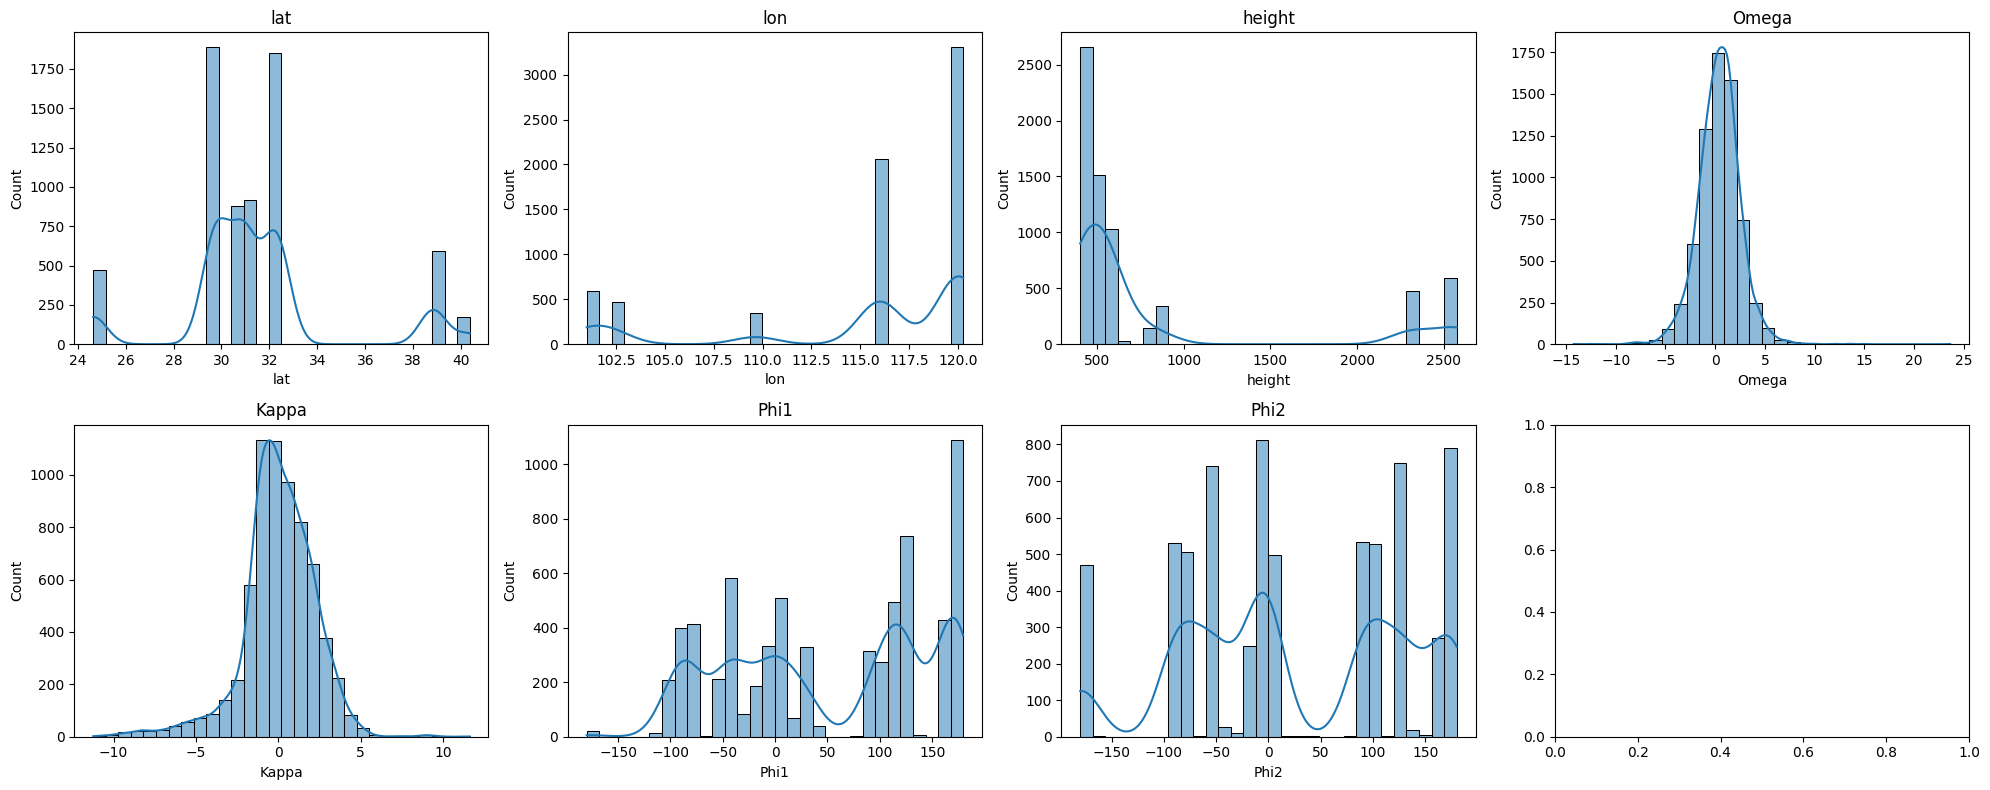

In [17]:
def plot_histograms(df, columns, rows=2, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        if i < len(axes):
            sns.histplot(df[col], kde=True, ax=axes[i], bins=30)
            axes[i].set_title(col)
    plt.tight_layout()
    plt.show()

plot_histograms(df, numeric_cols, rows=2, cols=4)


## Корелляция

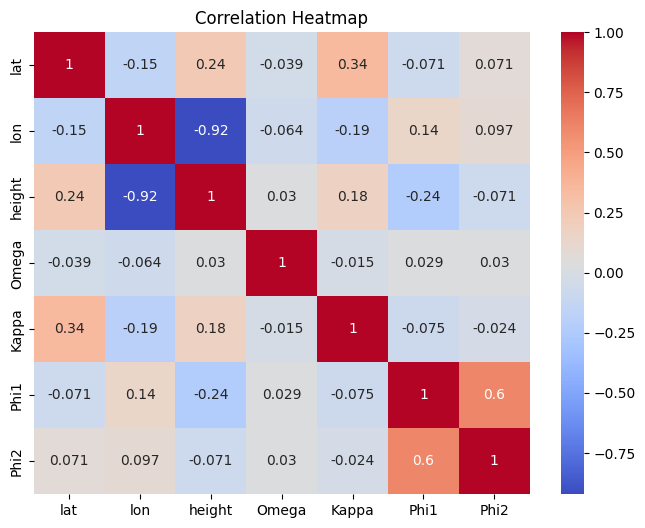

In [18]:
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [19]:
X = df[numeric_cols]
y = df["city_id"]  # для многоклассовой классификации


## Разбиваем на test и train

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(X_train.shape, X_test.shape)


(5419, 7) (1355, 7)


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, ConfusionMatrixDisplay
)

Test Accuracy: 0.8969607116382505


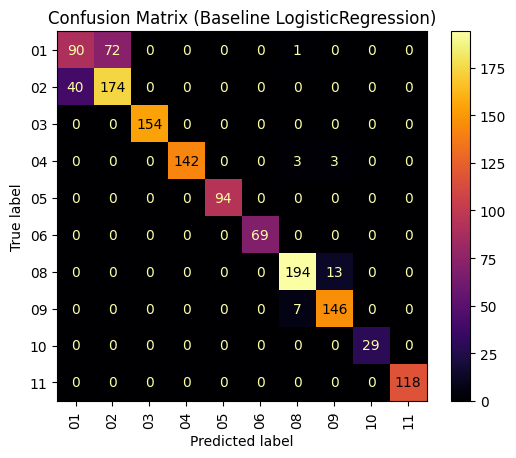

Classification Report:
              precision    recall  f1-score   support

          01       0.69      0.55      0.61       163
          02       0.71      0.81      0.76       214
          03       1.00      1.00      1.00       154
          04       1.00      0.96      0.98       148
          05       1.00      1.00      1.00        94
          06       1.00      1.00      1.00        69
          08       0.95      0.94      0.94       207
          09       0.90      0.95      0.93       153
          10       1.00      1.00      1.00        29
          11       1.00      1.00      1.00       118

    accuracy                           0.90      1349
   macro avg       0.92      0.92      0.92      1349
weighted avg       0.90      0.90      0.90      1349



In [27]:
# 1. Разделяем данные на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Удаляем строки с NaN
X_train_drop = X_train.dropna()
y_train_drop = y_train.loc[X_train_drop.index]

X_test_drop = X_test.dropna()
y_test_drop = y_test.loc[X_test_drop.index]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=10000, multi_class="multinomial"))
])

pipe.fit(X_train_drop, y_train_drop)

y_pred = pipe.predict(X_test_drop)

acc = accuracy_score(y_test_drop, y_pred)
print("Test Accuracy:", acc)

cm = confusion_matrix(y_test_drop, y_pred)

labels_for_display = np.sort(y_test_drop.unique())

disp = ConfusionMatrixDisplay(cm, display_labels=labels_for_display)
disp.plot(cmap="inferno", xticks_rotation="vertical")
plt.title("Confusion Matrix (Baseline LogisticRegression)")
plt.show()

print("Classification Report:")
print(classification_report(y_test_drop, y_pred, labels=labels_for_display))

In [ ]:
from sklearn.model_selection import GridSearchCV

model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=10000, multi_class="multinomial"))
])

param_grid = {
    "logreg__penalty": ["l1", "l2"],
    "logreg__C": np.logspace(-3, 2, 6),
    "logreg__solver": ["liblinear", "saga", "lbfgs"],
    "logreg__class_weight": [None, "balanced"]
}

grid_model = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_model.fit(X_train_drop, y_train_drop)

print("Best Params:", grid_model.best_params_)
print("Best CV Score:", grid_model.best_score_)


best_model = grid_model.best_estimator_
y_pred_gs = best_model.predict(X_test_drop)

acc_gs = accuracy_score(y_test_drop, y_pred_gs)
print("Test Accuracy after GridSearch:", acc_gs)

cm_gs = confusion_matrix(y_test_drop, y_pred_gs)
disp_gs = ConfusionMatrixDisplay(cm_gs, display_labels=np.sort(y_test_drop.unique()))
disp_gs.plot(cmap="inferno", xticks_rotation="vertical")
plt.title("Confusion Matrix (After GridSearch)")
plt.show()

print("Classification Report (After GridSearch):")
print(classification_report(y_test_drop, y_pred_gs, labels=np.sort(y_test_drop.unique())))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
